In [3]:
class_dict = {"apo-ferritin":1,"beta-amylase":2,"beta-galactosidase":3,"ribosome":4,"thyroglobulin":5,"virus-like-particle":6}

In [4]:
len(class_dict)

6

creating masks

In [5]:
def genrate_gaussain_kernal(shape,center,sigma):
    z , y , x = np.meshgrid(np.arange(shape[0]),np.arange(shape[1]),np.arange(shape[2]),indexing="ij")
    kernal = np.exp(-((z-center[0])**2+(y-center[1])**2+(x-center[2])**2)/(2*sigma**2))
    return kernal

In [6]:
import json

voxel_spacing = 20.024888392857143
num_classes = 6

def mask_genration_1(folder,particle_type):
    tomogram_shape = (92, 315, 315)
    heatmaps = np.zeros((num_classes,*tomogram_shape))
    with open("/kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns" + "/" + folder + "/" +"/Picks/" + particle_type + ".json") as f:
            particle_data = json.load(f)
    sigma = particle_radius[particle_type] / voxel_spacing / 2.0
    for point in particle_data['points']:
            x, y, z = point['location']['x'], point['location']['y'], point['location']['z']
            slice_index = int(z / voxel_spacing)  
            voxel_x = int(x / voxel_spacing)
            voxel_y = int(y / voxel_spacing)
            if 0 <= slice_index < tomogram_shape[0]:
                center = (slice_index,voxel_y,voxel_x)
                guassina = genrate_gaussain_kernal(tomogram_shape,center,sigma)
                class_index = list(particle_radius.keys()).index(particle_type)
                heatmaps[class_index] = np.maximum(heatmaps[class_index],guassina)
    return heatmaps

In [7]:
particle_radius = {
    'ribosome': 150.0,
    'virus-like-particle': 135.0,
    'apo-ferritin': 60.0,
    'beta-galactosidase': 90.0,
    'thyroglobulin': 130.0,
    "beta-amylase" : 75.0
}


In [8]:
tomogram_shape = (92, 315, 315)
def mask_genration_2(folder):
    combined_mask = np.zeros((num_classes,*tomogram_shape), dtype=np.uint8)
    for particle_type in particle_radius.keys():
        mask = mask_genration_1(folder,particle_type)
        combined_mask = np.maximum(combined_mask,mask)
    return combined_mask

In [9]:
import numpy as np
from tqdm import tqdm  # Import tqdm for progress bar

folders = ['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3','TS_99_9']
seg_masks = []

# Use tqdm to wrap the folders list for progress tracking
for f in tqdm(folders, desc="Processing Folders"):
    seg_masks.append(mask_genration_2(f))

Processing Folders: 100%|██████████| 7/7 [08:43<00:00, 74.77s/it]


In [10]:
np.array(seg_masks[0]).shape

(6, 92, 315, 315)

In [11]:
unique_values, counts = np.unique(seg_masks[0], return_counts=True)
print("Values:", unique_values)  
print("Counts:", counts)        


Values: [0.00000000e+000 4.94065646e-324 9.88131292e-324 ... 9.56949110e-001
 9.64983667e-001 1.00000000e+000]
Counts: [8071999   18608    8240 ...      66     186     140]


loading images

In [12]:
!pip install zarr

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 96.8 MB/s eta 0:00:00:00:0100:01
  Created wheel for asciitree: filename=asciitree-0.3.3-py3-none-any.whl size=5033 sha256=0e97e7d6c80d885ade1f1fc4ab125b5f7e7250aa2846d85d8c9e135333434a15
  Stored in directory: /root/.cache/pip/wheels/7f/4e/be/1171b40f43b918087657ec57cf3b81fa1a2e027d8755baa184
Successfully built asciitree


In [13]:
import os
import zarr

base_dir = "/kaggle/input/czii-cryo-et-object-identification/train/static/ExperimentRuns"
folders = ['TS_5_4', 'TS_69_2', 'TS_6_4', 'TS_6_6', 'TS_73_6', 'TS_86_3','TS_99_9']
zarr_files = ['denoised.zarr']
slices = {folder:{} for folder in folders}
all_images = []
for folder in folders:
    for zar in zarr_files:
        zarr_path = os.path.join(base_dir,folder,"VoxelSpacing10.000",zar)
        data = zarr.open(zarr_path,mode="r")
        slices[folder][zar] = data["1"][:]
        all_images.append(data["1"][:])

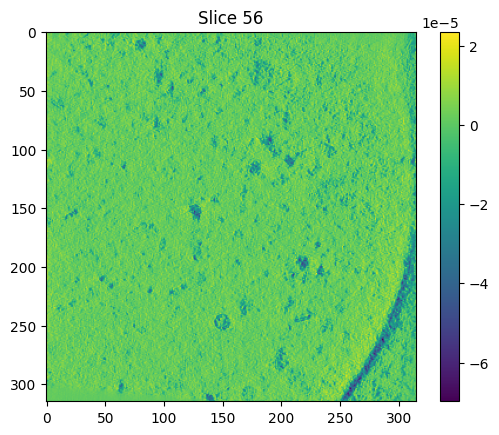

In [14]:
import matplotlib.pyplot as plt
import numpy as np

slice_index = 56

# Assuming `image` is your 3D array with shape (92, 315, 315)

plt.imshow(slices["TS_5_4"]["denoised.zarr"][slice_index], cmap='viridis')
plt.title(f"Slice {slice_index}")
plt.colorbar()
plt.show()


In [15]:
np.array(seg_masks).shape

(7, 6, 92, 315, 315)

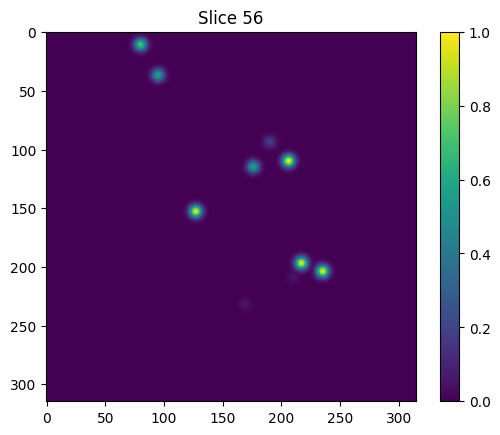

In [16]:
import matplotlib.pyplot as plt
import numpy as np

slice_index = 56

# Assuming `image` is your 3D array with shape (92, 315, 315)

plt.imshow(seg_masks[0][0][slice_index], cmap='viridis')
plt.title(f"Slice {slice_index}")
plt.colorbar()
plt.show()


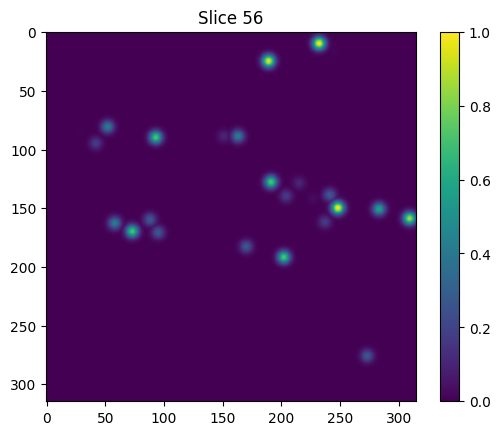

In [17]:
import matplotlib.pyplot as plt
import numpy as np

slice_index = 56

# Assuming `image` is your 3D array with shape (92, 315, 315)

plt.imshow(seg_masks[1][0][slice_index], cmap='viridis')
plt.title(f"Slice {slice_index}")
plt.colorbar()
plt.show()


In [18]:
np.array(seg_masks).shape

(7, 6, 92, 315, 315)

In [19]:
from torch.utils.data import Dataset
import torch
class ImageDataset(Dataset):
    def __init__(self,images,masks,image_transforms=None,mask_transforms=None):
        self.images = images
        self.masks = masks
        self.image_transforms = image_transforms
        self.mask_transforms = mask_transforms
        self.samples = []
        for folder , folder_data in images.items():
            for _,img_data in folder_data.items():
                self.samples.append((img_data,masks[folders.index(folder)]))
        
    def __len__(self):
        return len(self.samples)
    def __getitem__(self,index):
        images , masks = self.samples[index]
        images = torch.tensor(images,dtype=torch.float32)
        masks = torch.tensor(masks,dtype=torch.float32)
        transformed_images = []
        transformed_masks = []

        for i in range(images.shape[0]):
            if self.image_transforms:
                transformed_images.append(self.image_transforms(images[i]))

                slice_masks = []
                for j in range(masks.shape[0]):
                    slice_masks.append(self.mask_transforms(masks[j,i,:,:]))
                transformed_masks.append(torch.stack(slice_masks))
            

        transformed_images = torch.stack(transformed_images)
        transformed_masks = torch.stack(transformed_masks)
        transformed_images = transformed_images.squeeze(dim=1)  
        transformed_masks = transformed_masks.squeeze(dim=2)  
        transformed_masks = transformed_masks.permute(1, 0, 2, 3)
        return transformed_images , transformed_masks

In [20]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torchvision import transforms


mask_transforms = transforms.Compose([
    transforms.Lambda(lambda img: (img - img.min()) / (img.max() - img.min()) if img.max() > img.min() else img),
    transforms.ToPILImage(),  # Convert tensor/array to PIL image
    transforms.Resize((320, 320)),  # Resize the mask
    transforms.ToTensor()  # Convert back to tensor
])

image_transforms = transforms.Compose([
    transforms.Lambda(lambda img: (img - img.min()) / (img.max() - img.min()) if img.max() > img.min() else img),  # Normalize to [0, 1]
    transforms.ToPILImage(),  # Convert to RGB PIL image
    transforms.Resize((320, 320)),  # Resize the image
    transforms.ToTensor(),  # Convert back to tensor format with values in [0, 1]
])


from torch.utils.data import DataLoader, random_split

# Define the dataset

dataset = ImageDataset(images=slices,masks=seg_masks,image_transforms=image_transforms,mask_transforms=mask_transforms)

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)  # 80% for training
test_size = dataset_size - train_size # 20% for testing

# Split the dataset into training and testing
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

# Create DataLoader objects for both splits
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=False)

# train_loader is for training, test_loader is for testing






/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.0 (you have 1.4.15). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [21]:
for img , mask in train_dataset:
    print(f"Image shape: {img.shape}, Mask shape: {mask.shape}")

Image shape: torch.Size([92, 320, 320]), Mask shape: torch.Size([6, 92, 320, 320])
Image shape: torch.Size([92, 320, 320]), Mask shape: torch.Size([6, 92, 320, 320])
Image shape: torch.Size([92, 320, 320]), Mask shape: torch.Size([6, 92, 320, 320])
Image shape: torch.Size([92, 320, 320]), Mask shape: torch.Size([6, 92, 320, 320])
Image shape: torch.Size([92, 320, 320]), Mask shape: torch.Size([6, 92, 320, 320])


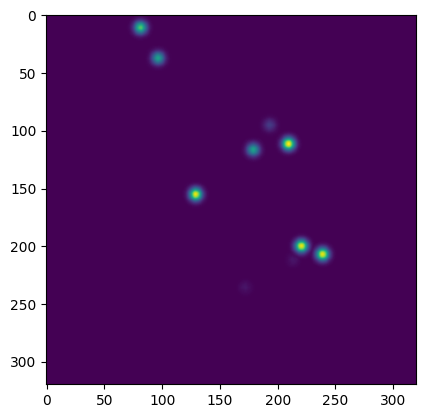

In [22]:
for img , mask in dataset:
    plt.imshow(mask[0][56], cmap = "viridis")
    break

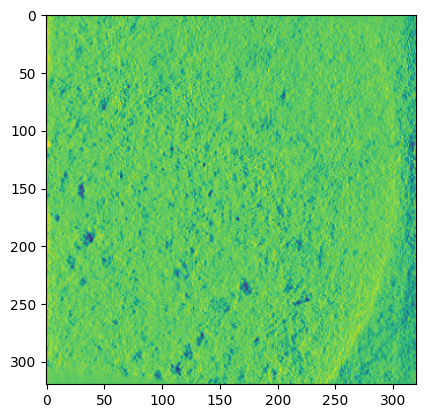

In [23]:
for img , mask in dataset:
    plt.imshow(img[67], cmap = "viridis")
    break

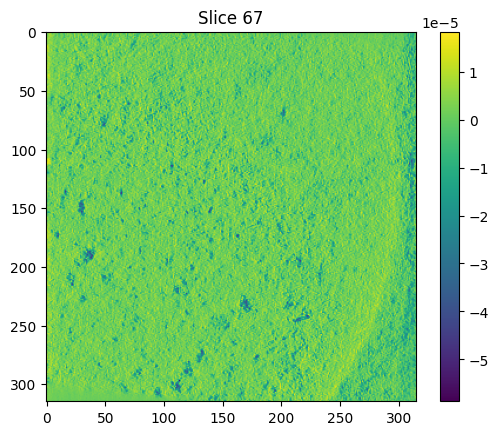

In [24]:
import matplotlib.pyplot as plt
import numpy as np

slice_index = 67

# Assuming `image` is your 3D array with shape (92, 315, 315)

plt.imshow(slices["TS_5_4"]["denoised.zarr"][slice_index], cmap='viridis')
plt.title(f"Slice {slice_index}")
plt.colorbar()
plt.show()


unet

In [25]:
import torch
import torch.nn as nn
import torch.nn.functional as F
class DoubleConvD(nn.Module):
    def __init__(self,in_channels,out_channels):
        super().__init__()
        self.double_con = nn.Sequential(
            nn.Conv2d(in_channels,out_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels,out_channels,kernel_size=3,padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self,x):
        return self.double_con(x)

In [26]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, num_classes=6):
        super().__init__()
        self.enc1 = DoubleConvD(in_channels, 64)
        self.enc2 = DoubleConvD(64, 128)
        self.enc3 = DoubleConvD(128, 256)
        self.enc4 = DoubleConvD(256, 512)

        self.bottleneck = DoubleConvD(512, 1024)

        # Adjust kernel size and stride to ensure proper upsampling
        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec4 = DoubleConvD(1024, 512)

        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec3 = DoubleConvD(512, 256)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec2 = DoubleConvD(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.dec1 = DoubleConvD(128, 64)

        self.final_conv = nn.Conv2d(64, num_classes, kernel_size=1)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        # Encoder path
        enc1 = self.enc1(x)
        enc1_pooled = self.pool(enc1)

        enc2 = self.enc2(enc1_pooled)
        enc2_pooled = self.pool(enc2)

        enc3 = self.enc3(enc2_pooled)
        enc3_pooled = self.pool(enc3)

        enc4 = self.enc4(enc3_pooled)
        enc4_pooled = self.pool(enc4)

        # Bottleneck
        bottleneck = self.bottleneck(enc4_pooled)

        # Decoder path

        up4 = self.up4(bottleneck)

        concat4 = torch.cat([enc4, up4], dim=1)  # Shapes align now
        dec4 = self.dec4(concat4)

        up3 = self.up3(dec4)
        concat3 = torch.cat([enc3, up3], dim=1)
        dec3 = self.dec3(concat3)

        up2 = self.up2(dec3)
        concat2 = torch.cat([enc2, up2], dim=1)
        dec2 = self.dec2(concat2)

        up1 = self.up1(dec2)
        concat1 = torch.cat([enc1, up1], dim=1)
        dec1 = self.dec1(concat1)

        return self.final_conv(dec1)


In [27]:
from torch.utils.data import DataLoader
import torch.optim as optim


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet().to(device)

In [28]:
for images, labels in train_loader:
    print(images.shape)  # Should be [batch_size, channels, depth, height, width]
    print(labels.shape)
    break


torch.Size([4, 92, 320, 320])
torch.Size([4, 6, 92, 320, 320])


In [29]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Define optimizer and scheduler
optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3)

criterion = nn.BCEWithLogitsLoss()  # Multi-label binary classification loss

num_epochs = 75
train_predictions = []
train_masks = []

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for images, masks in train_loader:  # Assuming `train_progress` is your DataLoader
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        batch_predictions = []

        # Process each slice
        for i in range(images.size(1)):  # Iterating through slices
            slice_images = images[:, i:i+1, :, :]  # Shape: [batch_size, 1, 320, 320]
            slice_masks = masks[:, :, i, :, :]  # Shape: [batch_size, num_classes, 320, 320]

            outputs = model(slice_images)  # Shape: [batch_size, num_classes, 320, 320]
            batch_predictions.append(outputs)

            # Compute loss for the current slice
            loss = criterion(outputs, slice_masks.float())  # BCEWithLogitsLoss expects logits and float targets
            loss.backward()
            train_loss += loss.item()

        optimizer.step()

        # Store predictions and masks for full-volume comparison
        batch_predictions = torch.stack(batch_predictions, dim=2)  # Shape: [batch_size, num_classes, 92, 320, 320]
        train_predictions.append(batch_predictions)
        train_masks.append(masks)

    # After processing the entire train_loader
    train_predictions = torch.cat(train_predictions, dim=0)  # Shape: [num_samples, num_classes, 92, 320, 320]
    train_masks = torch.cat(train_masks, dim=0)  # Shape: [num_samples, num_classes, 92, 320, 320]

    # Compute epoch loss
    avg_train_loss = train_loss / len(train_loader)
    scheduler.step(avg_train_loss)

  #  print(train_predictions.shape)
   # train_predictions_cpu = train_predictions.cpu().detach().numpy()  # Transfer to CPU and convert to numpy
    #unique_values, counts = np.unique(train_predictions_cpu, return_counts=True)
    #print("Values:", unique_values)
    #print("Counts:", counts)


    # Compute accuracy on the full volume
    train_predictions_sigmoid = torch.sigmoid(train_predictions)  # Apply sigmoid for probabilities
    predicted_classes = (train_predictions_sigmoid > 0.5).float()  # Threshold probabilities
    train_accuracy = (predicted_classes == train_masks).float().mean()

 #   predicted_classes_cpu = predicted_classes.cpu().detach().numpy()
  #  unique_values, counts = np.unique(predicted_classes_cpu, return_counts=True)
   # print("Values:", unique_values)
    #print("Counts:", counts)

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}, Accuracy: {train_accuracy * 100:.2f}%")

    # Clear stored predictions and masks for the next epoch
    train_predictions = []
    train_masks = []


Epoch [1/75], Loss: 54.7062, Accuracy: 80.14%
Epoch [2/75], Loss: 52.9520, Accuracy: 84.98%
Epoch [3/75], Loss: 51.8007, Accuracy: 86.53%
Epoch [4/75], Loss: 50.9947, Accuracy: 87.92%
Epoch [5/75], Loss: 50.3328, Accuracy: 89.57%
Epoch [6/75], Loss: 49.6673, Accuracy: 91.29%
Epoch [7/75], Loss: 49.0414, Accuracy: 92.83%
Epoch [8/75], Loss: 48.5345, Accuracy: 94.02%
Epoch [9/75], Loss: 47.8258, Accuracy: 94.98%
Epoch [10/75], Loss: 47.2650, Accuracy: 95.64%
Epoch [11/75], Loss: 46.6934, Accuracy: 96.11%
Epoch [12/75], Loss: 46.2428, Accuracy: 96.43%
Epoch [13/75], Loss: 45.7009, Accuracy: 96.69%
Epoch [14/75], Loss: 45.1736, Accuracy: 96.89%
Epoch [15/75], Loss: 44.5512, Accuracy: 97.06%
Epoch [16/75], Loss: 44.1918, Accuracy: 97.26%
Epoch [17/75], Loss: 43.6270, Accuracy: 97.45%
Epoch [18/75], Loss: 43.2920, Accuracy: 97.63%
Epoch [19/75], Loss: 42.8552, Accuracy: 97.72%
Epoch [20/75], Loss: 42.3935, Accuracy: 97.82%
Epoch [21/75], Loss: 41.9778, Accuracy: 97.89%
Epoch [22/75], Loss: 4

In [30]:
model.eval()  # Set model to evaluation mode
test_loss = 0.0
test_accuracy = 0.0

test_predictions = []
test_masks = []

with torch.no_grad():  # Disable gradient computation for testing
    for images, masks in test_loader:  # Assuming `test_loader` is your DataLoader
        images, masks = images.to(device), masks.to(device)

        batch_predictions = []

        # Process each slice
        for i in range(images.size(1)):  # Iterating through slices
            slice_images = images[:, i:i+1, :, :]  # Shape: [batch_size, 1, 320, 320]
            slice_masks = masks[:, :, i, :, :]  # Shape: [batch_size, num_classes, 320, 320]

            outputs = model(slice_images)  # Shape: [batch_size, num_classes, 320, 320]
            batch_predictions.append(outputs)

            # Compute loss for the current slice
            loss = criterion(outputs, slice_masks.float())
            test_loss += loss.item()

        # Store predictions and masks for full-volume comparison
        batch_predictions = torch.stack(batch_predictions, dim=2)  # Shape: [batch_size, num_classes, 92, 320, 320]
        test_predictions.append(batch_predictions)
        test_masks.append(masks)

# After processing the entire test_loader
test_predictions = torch.cat(test_predictions, dim=0)  # Shape: [num_samples, num_classes, 92, 320, 320]
test_masks = torch.cat(test_masks, dim=0)  # Shape: [num_samples, num_classes, 92, 320, 320]

# Compute average test loss
avg_test_loss = test_loss / len(test_loader)

# Compute accuracy on the full volume
test_predictions_sigmoid = torch.sigmoid(test_predictions)  # Apply sigmoid for probabilities
predicted_classes = (test_predictions_sigmoid > 0.5).float()  # Threshold probabilities
test_accuracy = (predicted_classes == test_masks).float().mean()

# Optional: Check unique predicted values
predicted_classes_cpu = predicted_classes.cpu().detach().numpy()
unique_values, counts = np.unique(predicted_classes_cpu, return_counts=True)
print("Unique Predicted Values:", unique_values)
print("Counts:", counts)

print(f"Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy * 100:.2f}%")


Unique Predicted Values: [0. 1.]
Counts: [112991226     58374]
Test Loss: 31.3202, Test Accuracy: 98.17%


In [47]:
torch.save(model.state_dict(), "unet_model.pth")